In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(f'Number of words in the file : {len(words)}')

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Number of words in the file : 32084


In [3]:
# Building VOCAB
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])  

torch.Size([182603, 3]) torch.Size([182603])
torch.Size([23085, 3]) torch.Size([23085])
torch.Size([22834, 3]) torch.Size([22834])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 24.1631
  10000/ 200000: 2.2767
  20000/ 200000: 2.2194
  30000/ 200000: 2.2801
  40000/ 200000: 2.5349
  50000/ 200000: 2.2253
  60000/ 200000: 2.5385
  70000/ 200000: 2.3214
  80000/ 200000: 1.8686
  90000/ 200000: 2.2708
 100000/ 200000: 2.1626
 110000/ 200000: 2.3097
 120000/ 200000: 2.1237
 130000/ 200000: 1.8928
 140000/ 200000: 1.9431
 150000/ 200000: 2.2633
 160000/ 200000: 2.4239
 170000/ 200000: 2.2477
 180000/ 200000: 2.1598
 190000/ 200000: 2.3296


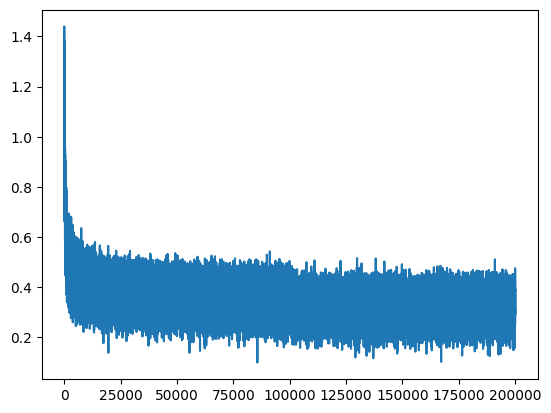

In [7]:
plt.plot(lossi)

In [48]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1+b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2483601570129395
val 2.2882094383239746


In [9]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 +b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)

      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mon.
ammyah.
see.
mad.
ryah.
rethrukendraege.
zeredieliigh.
poren.
eden.
van.
nar.
katelos.
kamin.
shuberging.
jest.
jairenel.
panthuna.
uszandel.
kylene.
eha.


### Scrutnising the loss

In [18]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [19]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'The initial loss as can be seen -->{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

The initial loss as can be seen -->      0/ 200000: 24.1631


In [21]:
print(f'Expected inital loss should be : {-torch.tensor(1/27.).log()}')

Expected inital loss should be : 3.295836925506592


In [25]:
logits[0]  ## THese should be closer to zero. -- coming out of NN

tensor([  5.4201, -22.1451,  -5.9226,   0.6275, -11.5028, -11.4785, -17.7857,
        -10.1156,  22.3517,  -3.9162, -16.4996,  -4.6402,  -1.3280, -12.1889,
         17.9498,   2.8496, -24.5273,   4.4647,  -5.6790,  -0.0944,  -0.6234,
         -5.7993,  11.5429,  -7.1719,  11.1470,   3.1095,  -1.2456],
       grad_fn=<SelectBackward0>)

### Changing few things to set the init loss proper

* Setting b2 = 0 and W2 closer to zero -- `want the logits closer to zero`
*

In [84]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # Setting it to 0.1 will black out all the h to be black
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 # added to remove any random bias

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [85]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer -- for logits to be closer to zero need W2 to be closer to zero
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'The initial loss as can be seen -->{i:7d}/{max_steps:7d}: {loss.item():.4f}, now much closer to {-torch.tensor(1/27.).log():4f}')
  lossi.append(loss.log10().item())
  break

The initial loss as can be seen -->      0/ 100000: 3.3017, now much closer to 3.295837


In [73]:
#plt.plot(lossi)

In [8]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1+b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1144673824310303
val 2.1554675102233887


### Another issue : tanh

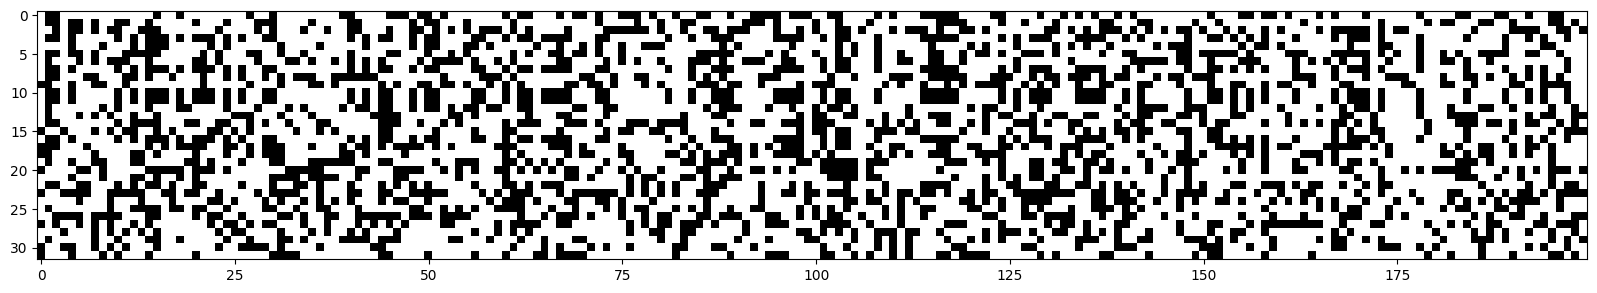

In [65]:
## SInce most of the outputs of h are -1, 1 therefore that would kill the gradient for tanh. --> Vanishing Gradient
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99, cmap ='gray', interpolation = 'nearest')

# A lot of the place is white which means tanh was -1 ,1 therefore many of them were dead

#X axis is neurons
# No dead neuronn as can be seen
# too many vaue being -1 and 1

### Actual issue is that the h pre activation is giving us the very large range values leading the tanh to give -1 and 1 for most of those inputs  --- Therefore we want hpreac to be closer to zero

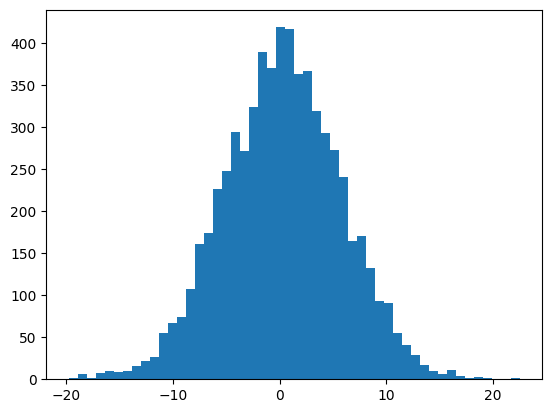

In [66]:
# Before applying the activation
plt.hist(hpreact.view(-1).tolist(), 50);

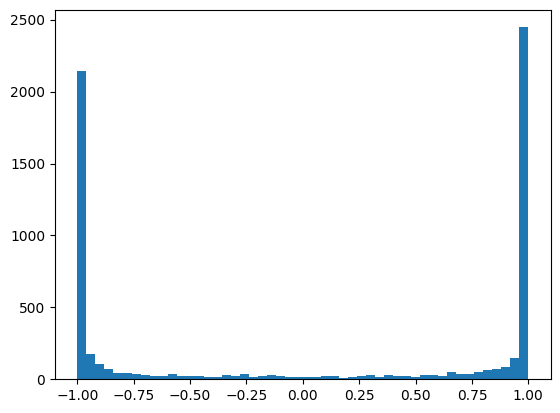

In [67]:
#After applying activation
plt.hist(h.view(-1).tolist(), 50);

### Making changes of multiplying W2 with 0.2

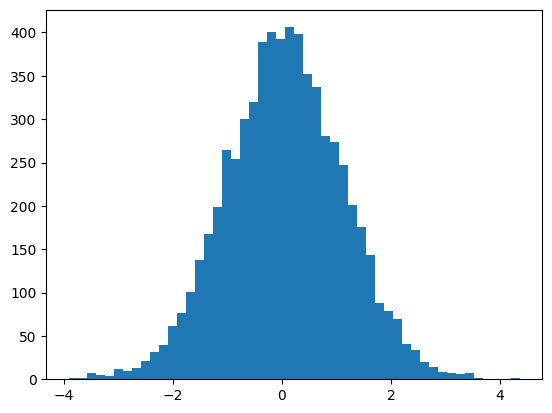

In [86]:
# Before applying the activation
plt.hist(hpreact.view(-1).tolist(), 50);

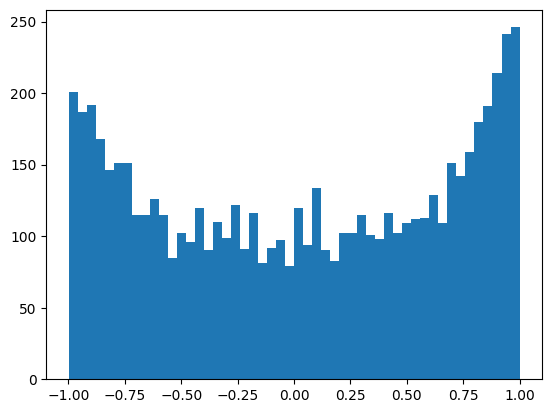

In [87]:
#After applying activation
plt.hist(h.view(-1).tolist(), 50);

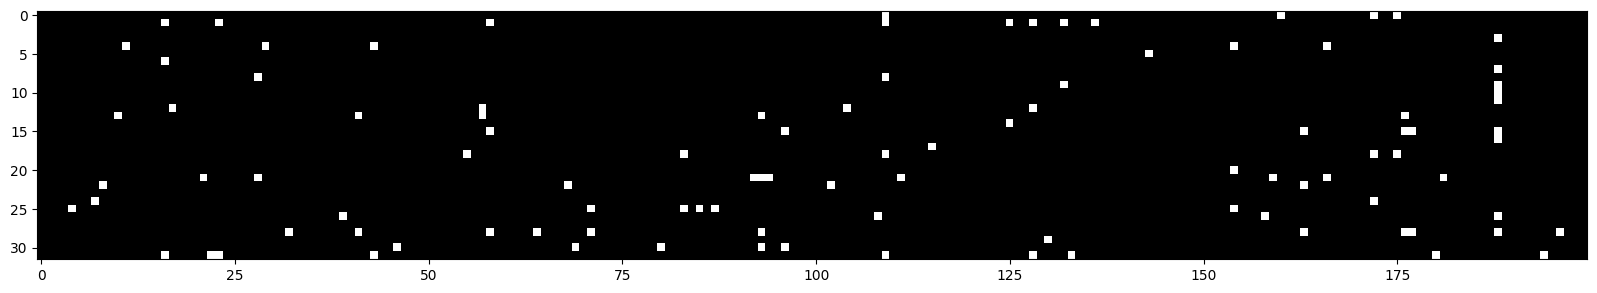

In [88]:
## SInce most of the outputs of h are -1, 1 therefore that would kill the gradient for tanh. --> Vanishing Gradient
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99, cmap ='gray', interpolation = 'nearest')

# A lot of the place is white which means tanh was -1 ,1 therefore many of them were dead

#X axis is neurons
# No dead neuronn as can be seen
# All black

### Running once again with new init

In [92]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # Setting it to 0.1 will black out all the h to be black
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 # added to remove any random bias

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [93]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer -- for logits to be closer to zero need W2 to be closer to zero
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'loss -->{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

loss -->      0/ 200000: 3.3017
loss -->  10000/ 200000: 1.8750
loss -->  20000/ 200000: 2.2104
loss -->  30000/ 200000: 2.1252
loss -->  40000/ 200000: 2.3111
loss -->  50000/ 200000: 1.8897
loss -->  60000/ 200000: 1.9787
loss -->  70000/ 200000: 2.0474
loss -->  80000/ 200000: 1.7339
loss -->  90000/ 200000: 2.0117
loss --> 100000/ 200000: 2.0633
loss --> 110000/ 200000: 2.2039
loss --> 120000/ 200000: 1.9305
loss --> 130000/ 200000: 1.8185
loss --> 140000/ 200000: 1.9908
loss --> 150000/ 200000: 2.0839
loss --> 160000/ 200000: 2.2124
loss --> 170000/ 200000: 2.0721
loss --> 180000/ 200000: 2.2034
loss --> 190000/ 200000: 2.1859


In [94]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1+b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.036297082901001
val 2.097700357437134


## Results summary : loss log
 
* Original 
**train** 2.2483601570129395 ----
**val** 2.2882094383239746

* Using softmax confidently
**train** 2.1144673824310303 ----
**val** 2.1554675102233887

* using tanhlayer too saturated at init
**train** 2.036297082901001 -----
**Val** 2.097700357437134

 
 
 
 